In [3]:
!pip install pycountry
!pip install numpy
import requests
import pandas as pd
import pycountry
import numpy as np
import mysql.connector
import requests
from datetime import datetime

username = "princy"
password = "Pass123#"
host = "localhost"
database_name = "nutrition"
conn_root = mysql.connector.connect(
    host=host,
    user=username,
    password=password
)

cursor_root = conn_root.cursor()
cursor_root.execute(f"CREATE DATABASE IF NOT EXISTS {database_name};")
conn_root.commit()

cursor_root.close()
conn_root.close()
conn = mysql.connector.connect(
    host=host,
    user=username,
    password=password,
    database=database_name
)
cursor = conn.cursor()

create_obesity_table_query = """CREATE TABLE IF NOT EXISTS obesity (
    Year INT,
    Gender VARCHAR(10),
    Mean_Estimate FLOAT,
    LowerBound FLOAT,
    UpperBound FLOAT,
    Age_Group VARCHAR(10),
    Country VARCHAR(100),
    Region VARCHAR(50),
    CI_Width FLOAT,
    Obesity_level VARCHAR(10)
);"""

cursor.execute(create_obesity_table_query)
cursor.execute("TRUNCATE TABLE nutrition.obesity;")

create_malnutrition_table_query = """CREATE TABLE IF NOT EXISTS malnutrition (
    Year INT,
    Gender VARCHAR(10),
    Mean_Estimate FLOAT,
    LowerBound FLOAT,
    UpperBound FLOAT,
    Age_Group VARCHAR(10),
    Country VARCHAR(100),
    Region VARCHAR(50),
    CI_Width FLOAT,
    Malnutrition_Level VARCHAR(10)
);"""

cursor.execute(create_malnutrition_table_query)
cursor.execute("TRUNCATE TABLE nutrition.malnutrition;")

conn.commit()

custom_country_names = {
                    'GLOBAL': 'Global',
                    'WB_LMI': 'Low & Middle Income',
                    'WB_HI': 'High Income',
                    'WB_LI': 'Low Income',
                    'EMR': 'Eastern Mediterranean Region',
                    'EUR': 'Europe',
                    'AFR': 'Africa',
                    'SEAR': 'South-East Asia Region',
                    'WPR': 'Western Pacific Region',
                    'AMR': 'Americas Region',
                    'WB_UMI': 'Upper Middle Income'}

def get_country_name(code):
    if(code in custom_country_names):
        return custom_country_names[code]
    try:
        return pycountry.countries.get(alpha_3=code).name
    except:
        print(code)
        return code
        
    

obesity_adult_url = "https://ghoapi.azureedge.net/api/NCD_BMI_30C"
obesity_child_url = "https://ghoapi.azureedge.net/api/NCD_BMI_PLUS2C"
mal_adult_url = "https://ghoapi.azureedge.net/api/NCD_BMI_18C"
mal_child_url = "https://ghoapi.azureedge.net/api/NCD_BMI_MINUS2C"

obesity_adult_json = requests.get(obesity_adult_url).json()
obesity_child_json = requests.get(obesity_child_url).json()
mal_adult_json = requests.get(mal_adult_url).json()
mal_child_json = requests.get(mal_child_url).json()

obesity_adult_df = pd.DataFrame(obesity_adult_json["value"])
obesity_child_df = pd.DataFrame(obesity_child_json["value"])
mal_adult_df =  pd.DataFrame(mal_adult_json["value"])
mal_child_df = pd.DataFrame(mal_child_json["value"])

obesity_adult_df["age_Group"] = "Adult"
obesity_child_df["age_Group"] = "Child"
mal_adult_df["age_Group"] = "Adult"
mal_child_df["age_Group"] = "Child"

obesity_df = pd.concat(
    [obesity_adult_df, obesity_child_df],
    ignore_index=True
)
malnutrition_df = pd.concat(
    [mal_adult_df, mal_child_df],
    ignore_index=True
)

obesity_df_filtered = obesity_df[obesity_df["TimeDim"].between(2012,2022)]
malnutrition_df_filtered = malnutrition_df[malnutrition_df["TimeDim"].between(2012,2022)]

columns_to_keep = ["ParentLocation", "Dim1", "TimeDim", "Low", "High", "NumericValue", "SpatialDim", "age_Group"]
obesity_df_final = obesity_df_filtered[columns_to_keep]
malnutrition_df_final = malnutrition_df_filtered[columns_to_keep]

obesity_df_final = obesity_df_final.rename(columns ={"ParentLocation":"Region", "Dim1":"Gender", "TimeDim":"Year", "Low":"LowerBound", "High":"UpperBound", "NumericValue":"Mean_Estimate", "SpatialDim":"Country", "age_Group":"Age_Group"})
malnutrition_df_final = malnutrition_df_final.rename(columns ={"ParentLocation":"Region", "Dim1":"Gender", "TimeDim":"Year", "Low":"LowerBound", "High":"UpperBound", "NumericValue":"Mean_Estimate", "SpatialDim":"Country", "age_Group":"Age_Group"})

gender_mapping = {"SEX_MLE": "Male", "SEX_FMLE": "Female", "SEX_BTSX":"Both"}
obesity_df_final["Gender"] = obesity_df_final["Gender"].map(gender_mapping)
malnutrition_df_final["Gender"] = malnutrition_df_final["Gender"].map(gender_mapping)

obesity_df_final["Country"] = obesity_df_final["Country"].apply(get_country_name)
malnutrition_df_final["Country"] = malnutrition_df_final["Country"].apply(get_country_name)

obesity_df_final["CI_Width"] = obesity_df_final["UpperBound"] - obesity_df_final["LowerBound"]
malnutrition_df_final["CI_Width"] = malnutrition_df_final["UpperBound"] - malnutrition_df_final["LowerBound"]

obesity_df_final["Mean_Estimate"] = pd.to_numeric(
    obesity_df_final["Mean_Estimate"], errors="coerce"
)

malnutrition_df_final["Mean_Estimate"] = pd.to_numeric(
    malnutrition_df_final["Mean_Estimate"], errors="coerce"
)


obesity_conditions = [obesity_df_final["Mean_Estimate"]>=30, (obesity_df_final["Mean_Estimate"]>=25) & (obesity_df_final["Mean_Estimate"]<=29.9), obesity_df_final["Mean_Estimate"]<25]
obesity_choices = ["High", "Moderate","Low"] 
obesity_df_final["Obesity_level"] = np.select(obesity_conditions,obesity_choices,default="NA")

malnutrition_conditions = [malnutrition_df_final["Mean_Estimate"]>=20, (malnutrition_df_final["Mean_Estimate"]>=10) & (malnutrition_df_final["Mean_Estimate"]<=19.9), malnutrition_df_final["Mean_Estimate"]<10]
malnutrition_choices = ["High", "Moderate","Low"] 
malnutrition_df_final["Malnutrition_Level"] = np.select(malnutrition_conditions,malnutrition_choices,default="NA")

insert_obesity_query = """
INSERT INTO nutrition.obesity
(Region, Gender, Year, LowerBound, UpperBound, Mean_Estimate,
 Country, Age_Group, CI_Width, Obesity_level)
VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
"""

for _, row in obesity_df_final.iterrows():
        cursor.execute(
        insert_obesity_query,
        (
            row["Region"],
            row["Gender"],
            row["Year"],
            row["LowerBound"],
            row["UpperBound"],
            row["Mean_Estimate"],
            row["Country"],
            row["Age_Group"],
            row["CI_Width"],
            row["Obesity_level"]
        )
    )

insert_malnutrition_query = """
INSERT INTO nutrition.malnutrition
(Region, Gender, Year, LowerBound, UpperBound, Mean_Estimate,
 Country, Age_Group, CI_Width, Malnutrition_Level)
VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
"""

for _, row in malnutrition_df_final.iterrows():
    cursor.execute(
        insert_malnutrition_query,
        (
            row["Region"],
            row["Gender"],
            row["Year"],
            row["LowerBound"],
            row["UpperBound"],
            row["Mean_Estimate"],
            row["Country"],
            row["Age_Group"],
            row["CI_Width"],
            row["Malnutrition_Level"]
        )
    )
conn.commit()

In [7]:
#EDA
obesity_df_final.shape

(27720, 10)

In [8]:
malnutrition_df_final.shape

(27720, 10)

In [9]:
obesity_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27720 entries, 2 to 83154
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Region         26268 non-null  object 
 1   Gender         27720 non-null  object 
 2   Year           27720 non-null  int64  
 3   LowerBound     27720 non-null  float64
 4   UpperBound     27720 non-null  float64
 5   Mean_Estimate  27720 non-null  float64
 6   Country        27720 non-null  object 
 7   Age_Group      27720 non-null  object 
 8   CI_Width       27720 non-null  float64
 9   Obesity_level  27720 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 2.3+ MB


In [10]:
malnutrition_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27720 entries, 0 to 83159
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Region              26268 non-null  object 
 1   Gender              27720 non-null  object 
 2   Year                27720 non-null  int64  
 3   LowerBound          27720 non-null  float64
 4   UpperBound          27720 non-null  float64
 5   Mean_Estimate       27720 non-null  float64
 6   Country             27720 non-null  object 
 7   Age_Group           27720 non-null  object 
 8   CI_Width            27720 non-null  float64
 9   Malnutrition_Level  27720 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 2.3+ MB


In [11]:
obesity_df_final.describe()

Year    LowerBound    UpperBound  Mean_Estimate      CI_Width
count  27720.000000  27720.000000  27720.000000   27720.000000  27720.000000
mean    2017.000000      9.393155     17.068488      12.761040      7.675334
std        3.162335      9.893854     12.395013      10.858925      6.616899
min     2012.000000      0.077541      0.547848       0.265672      0.216695
25%     2014.000000      2.354433      7.875503       4.753964      2.926708
50%     2017.000000      6.506534     13.704382       9.944541      5.480536
75%     2020.000000     12.697752     23.986050      17.482417     10.338880
max     2022.000000     74.365371     87.868512      80.609250     40.554062

In [12]:
malnutrition_df_final.describe()

Year    LowerBound    UpperBound  Mean_Estimate      CI_Width
count  27720.000000  27720.000000  27720.000000   27720.000000  27720.000000
mean    2017.000000      3.397094      8.147889       5.354451      4.750795
std        3.162335      3.908061      6.443692       4.811220      4.257683
min     2012.000000      0.023703      0.354833       0.175309      0.166679
25%     2014.000000      1.053666      3.143307       2.039278      1.603222
50%     2017.000000      1.907971      6.095557       3.597794      3.351093
75%     2020.000000      4.186440     11.526301       7.335245      6.530869
max     2022.000000     31.365401     43.680286      35.894114     26.701744

In [13]:
obesity_df_final.columns

Index(['Region', 'Gender', 'Year', 'LowerBound', 'UpperBound', 'Mean_Estimate',
       'Country', 'Age_Group', 'CI_Width', 'Obesity_level'],
      dtype='object')

In [14]:
malnutrition_df_final.columns

Index(['Region', 'Gender', 'Year', 'LowerBound', 'UpperBound', 'Mean_Estimate',
       'Country', 'Age_Group', 'CI_Width', 'Malnutrition_Level'],
      dtype='object')

In [20]:
obesity_df_final.isnull().any()

Region            True
Gender           False
Year             False
LowerBound       False
UpperBound       False
Mean_Estimate    False
Country          False
Age_Group        False
CI_Width         False
Obesity_level    False
dtype: bool

In [21]:
malnutrition_df_final.isnull().any()

Region                 True
Gender                False
Year                  False
LowerBound            False
UpperBound            False
Mean_Estimate         False
Country               False
Age_Group             False
CI_Width              False
Malnutrition_Level    False
dtype: bool

In [22]:
obesity_df_final.isnull().sum()

Region           1452
Gender              0
Year                0
LowerBound          0
UpperBound          0
Mean_Estimate       0
Country             0
Age_Group           0
CI_Width            0
Obesity_level       0
dtype: int64

In [23]:
malnutrition_df_final.isnull().sum()

Region                1452
Gender                   0
Year                     0
LowerBound               0
UpperBound               0
Mean_Estimate            0
Country                  0
Age_Group                0
CI_Width                 0
Malnutrition_Level       0
dtype: int64

In [24]:
obesity_df_final.nunique()

Region               6
Gender               3
Year                11
LowerBound       27713
UpperBound       27702
Mean_Estimate    27712
Country            210
Age_Group            2
CI_Width         27718
Obesity_level        4
dtype: int64

In [25]:
malnutrition_df_final.nunique()

Region                    6
Gender                    3
Year                     11
LowerBound            27713
UpperBound            27704
Mean_Estimate         27706
Country                 210
Age_Group                 2
CI_Width              27718
Malnutrition_Level        4
dtype: int64

In [35]:
obesity_df_final[['Mean_Estimate', 'CI_Width']].describe()

Mean_Estimate      CI_Width
count   27720.000000  27720.000000
mean       12.761040      7.675334
std        10.858925      6.616899
min         0.265672      0.216695
25%         4.753964      2.926708
50%         9.944541      5.480536
75%        17.482417     10.338880
max        80.609250     40.554062

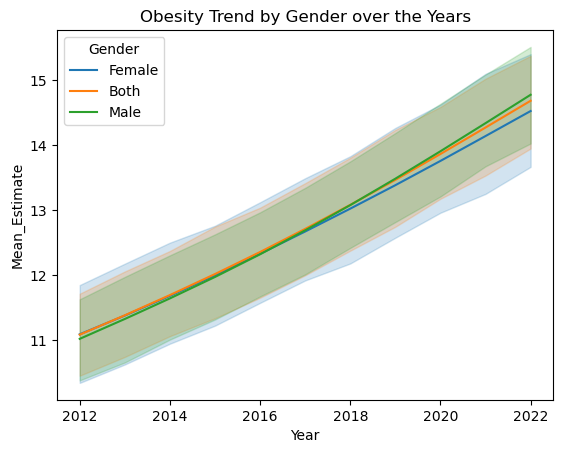

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
sns.lineplot(data = obesity_df_final, x='Year', y='Mean_Estimate', hue='Gender')
plt.title("Obesity Trend by Gender over the Years")
plt.show()

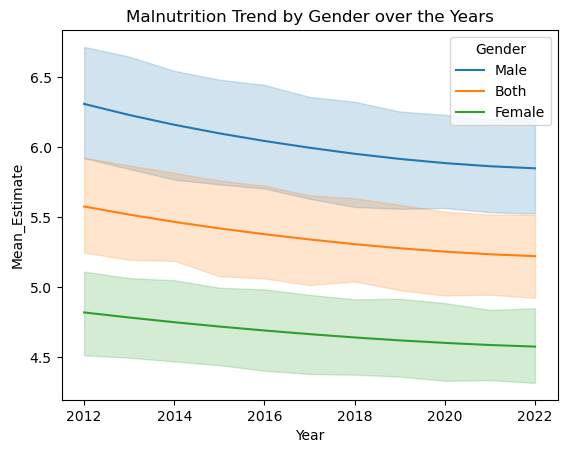

In [74]:
sns.lineplot(data = malnutrition_df_final, x='Year', y='Mean_Estimate', hue='Gender')
plt.title("Malnutrition Trend by Gender over the Years")
plt.show()

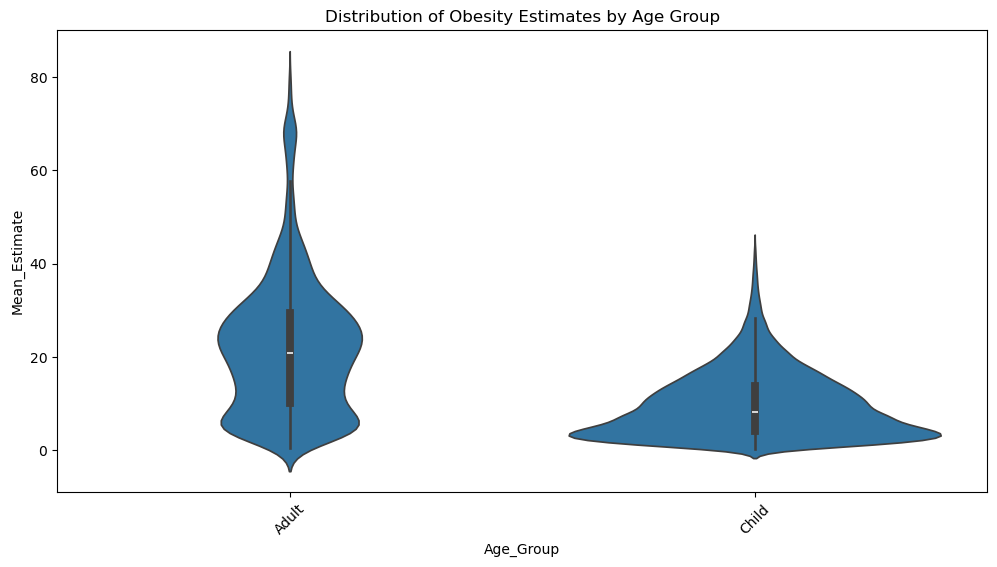

In [58]:
plt.figure(figsize=(12,6))
sns.violinplot(data=obesity_df_final, x='Age_Group', y='Mean_Estimate')
plt.title("Distribution of Obesity Estimates by Age Group")
plt.xticks(rotation=45)
plt.show()

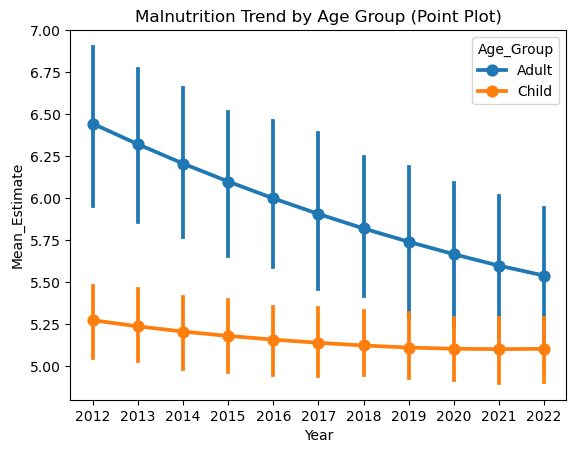

In [59]:
sns.pointplot(data=malnutrition_df_final, x='Year', y='Mean_Estimate', hue='Age_Group')
plt.title("Malnutrition Trend by Age Group (Point Plot)")
plt.show()

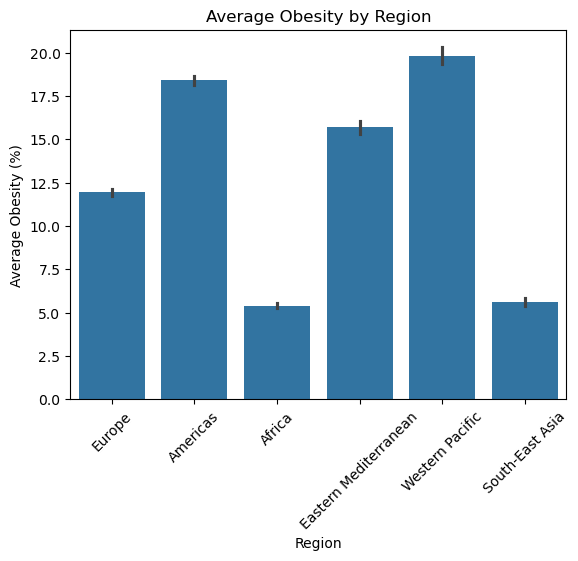

In [48]:
region_avg = obesity_df_final.groupby('Region')['Mean_Estimate'].mean().reset_index()
sns.barplot(data=obesity_df_final, x='Region', y='Mean_Estimate')
plt.xticks(rotation=45)
plt.ylabel('Average Obesity (%)')
plt.title('Average Obesity by Region')
plt.show()

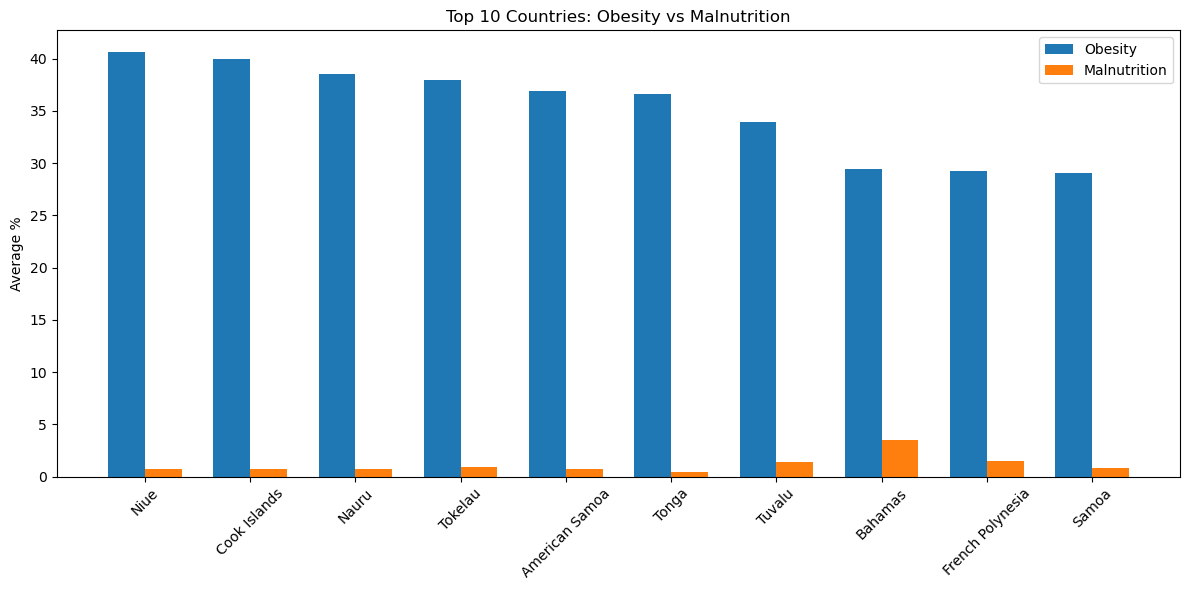

In [51]:
obesity_avg = obesity_df_final.groupby('Country')['Mean_Estimate'].mean().reset_index(name='Avg_Obesity')
malnutrition_avg = malnutrition_df_final.groupby('Country')['Mean_Estimate'].mean().reset_index(name='Avg_Malnutrition')

country_compare = obesity_avg.merge(malnutrition_avg, on='Country')
top10_countries = country_compare.sort_values(by='Avg_Obesity', ascending=False).head(10)

x = np.arange(len(top10_countries['Country']))
width = 0.35
plt.figure(figsize=(12,6))
plt.bar(x - width/2, top10_countries['Avg_Obesity'], width, label='Obesity')
plt.bar(x + width/2, top10_countries['Avg_Malnutrition'], width, label='Malnutrition')
plt.xticks(x, top10_countries['Country'], rotation=45)
plt.ylabel('Average %')
plt.title('Top 10 Countries: Obesity vs Malnutrition')
plt.legend()
plt.tight_layout()
plt.show()

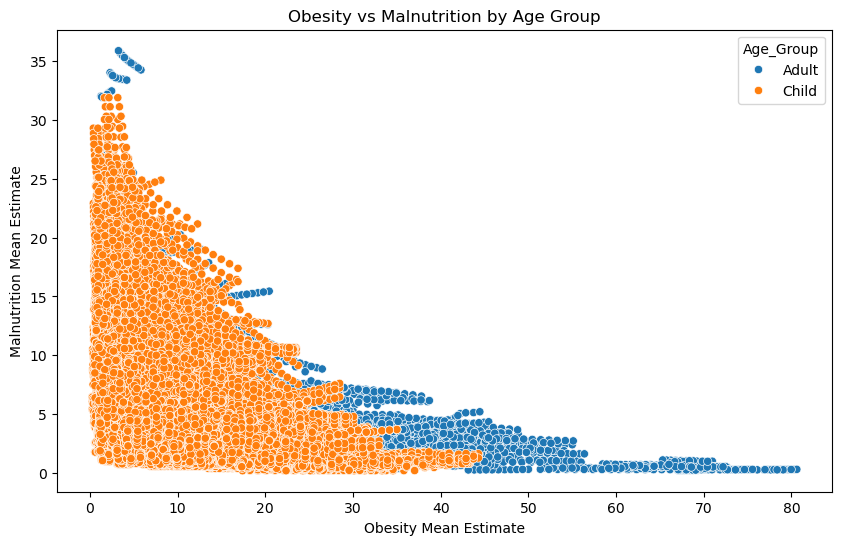

In [67]:
merged = obesity_df_final.merge(
    malnutrition_df_final,
    on=["Country", "Year", "Age_Group", "Gender", "Region"],
    suffixes=("_obesity", "_mal")
)

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=merged,
    x="Mean_Estimate_obesity",
    y="Mean_Estimate_mal",
    hue="Age_Group"
)
plt.xlabel("Obesity Mean Estimate")
plt.ylabel("Malnutrition Mean Estimate")
plt.title("Obesity vs Malnutrition by Age Group")
plt.show()

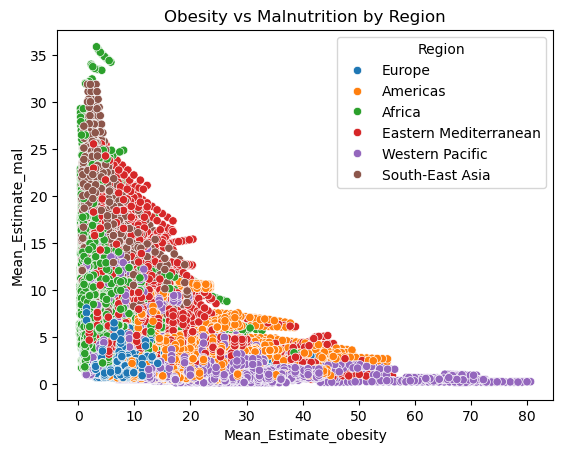

In [68]:
sns.scatterplot(
    data=merged,
    x="Mean_Estimate_obesity",
    y="Mean_Estimate_mal",
    hue="Region"
)
plt.title("Obesity vs Malnutrition by Region")
plt.show()

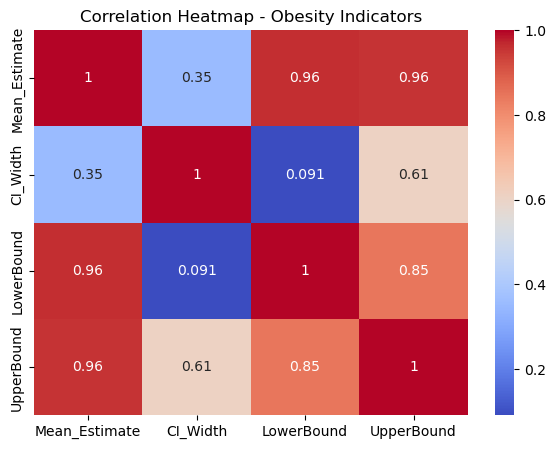

In [54]:
numeric_cols = obesity_df_final[["Mean_Estimate","CI_Width","LowerBound","UpperBound"]]
corr = numeric_cols.corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap - Obesity Indicators")
plt.show()

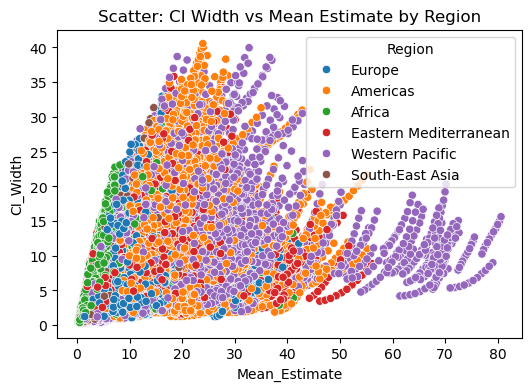

In [55]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=obesity_df_final, x="Mean_Estimate", y="CI_Width", hue="Region")
plt.title("Scatter: CI Width vs Mean Estimate by Region")
plt.show()

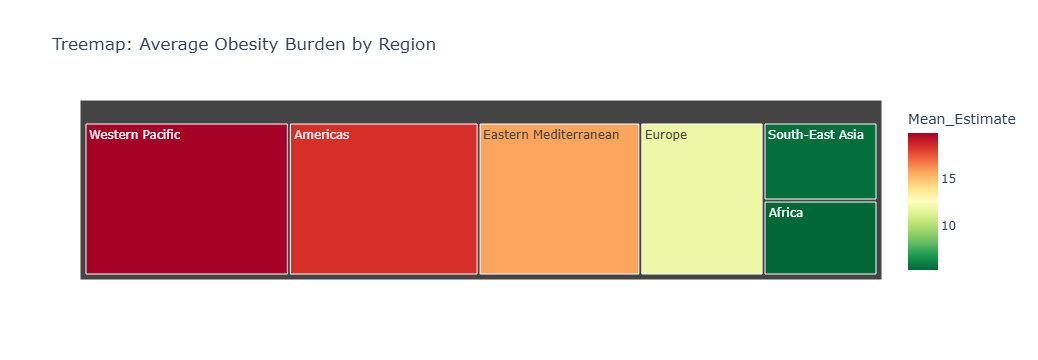

In [77]:
df_region = obesity_df_final.groupby("Region")["Mean_Estimate"].mean().reset_index()

fig = px.treemap(
    df_region,
    path=["Region"],
    values="Mean_Estimate",
    color="Mean_Estimate",
    color_continuous_scale="RdYlGn_r",
    title="Treemap: Average Obesity Burden by Region"
)
fig.show()

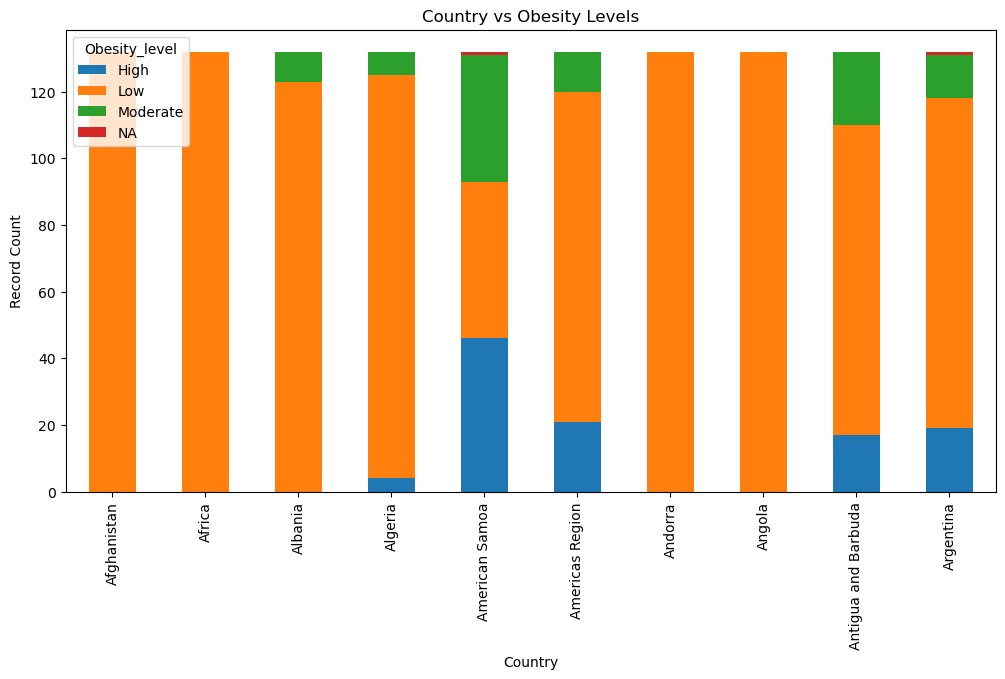

In [86]:
count_df = obesity_df_final.groupby(["Country","Obesity_level"]).size().unstack(fill_value=0)

count_df.head(10).plot(kind='bar', stacked=True, figsize=(12,6))
plt.ylabel("Record Count")
plt.title("Country vs Obesity Levels")
plt.show()

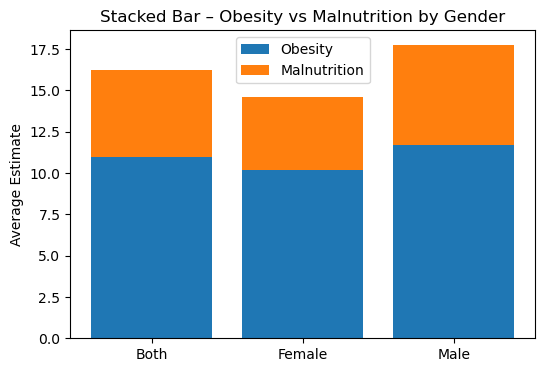

In [87]:
gender_stats = merged.groupby("Gender")[
    ["Mean_Estimate_obesity", "Mean_Estimate_mal"]
].mean().reset_index()
plt.figure(figsize=(6,4))
plt.bar(gender_stats["Gender"], gender_stats["Mean_Estimate_obesity"], label="Obesity")
plt.bar(gender_stats["Gender"], gender_stats["Mean_Estimate_mal"], 
        bottom=gender_stats["Mean_Estimate_obesity"], 
        label="Malnutrition")

plt.ylabel("Average Estimate")
plt.title("Stacked Bar – Obesity vs Malnutrition by Gender")
plt.legend()
plt.show()

In [112]:
from IPython.display import display, Markdown
display(Markdown("### Obesity Queries"))

### Obesity Queries

In [97]:
import warnings
warnings.filterwarnings('ignore')
query1 = """
SELECT COALESCE(region, 'Unknown') AS Region, 
       AVG(mean_estimate) AS avg_obesity_level
FROM nutrition.obesity
WHERE year = (SELECT MAX(year) FROM nutrition.obesity)
GROUP BY COALESCE(region, 'Unknown')
ORDER BY avg_obesity_level DESC
LIMIT 5;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Top 5 Regions by Average Obesity Level"))
display(df)

### Top 5 Regions by Average Obesity Level

Region  avg_obesity_level
0        Western Pacific          22.639636
1               Americas          21.213601
2  Eastern Mediterranean          18.126910
3                 Europe          12.987338
4                Unknown          11.462648

In [98]:
query1 = """
select country, avg(mean_estimate) as avg_obesity_level from nutrition.obesity 
group by country order by avg_obesity_level desc limit 5;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Top 5 Countries with Highest Obesity Estimates"))
display(df)

### Top 5 Countries with Highest Obesity Estimates

country  avg_obesity_level
0            Niue          40.664873
1    Cook Islands          39.917173
2           Nauru          38.512100
3         Tokelau          37.960966
4  American Samoa          36.892015

In [100]:
query1 = """
select year, avg(mean_estimate) as avg_obesity_level from nutrition.obesity 
where country = 'India'
group by year order by year;;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Obesity trend in India over the Years(Mean_estimate)"))
display(df)

### Obesity trend in India over the Years(Mean_estimate)

year  avg_obesity_level
0   2012           2.473178
1   2013           2.634653
2   2014           2.798749
3   2015           2.972813
4   2016           3.159576
5   2017           3.362175
6   2018           3.579292
7   2019           3.809013
8   2020           4.051149
9   2021           4.307816
10  2022           4.579179

In [101]:
query1 = """
select gender, avg(mean_estimate) as avg_obesity_level from nutrition.obesity group by gender;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Average Obesity by Gender "))
display(df)

### Average Obesity by Gender 

gender  avg_obesity_level
0  Female          12.724456
1    Both          12.781969
2    Male          12.776696

In [104]:
query1 = """
select count(distinct(country)) as Country_count, obesity_level, age_group from nutrition.obesity 
group by obesity_level, age_group;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Country Count by Obesity Level Category and Age Group "))
display(df)

### Country Count by Obesity Level Category and Age Group 

Country_count obesity_level age_group
0             94          High     Adult
1             11          High     Child
2            176           Low     Adult
3            210           Low     Child
4             99      Moderate     Adult
5             26      Moderate     Child
6             17            NA     Adult
7              7            NA     Child

In [105]:
query1 = """
select country, avg(ci_width) as avg_ci_width from nutrition.obesity
group by country order by avg_ci_width desc limit 5;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Top 5 Countries Least Reliable"))
display(df)

### Top 5 Countries Least Reliable

country  avg_ci_width
0              Bermuda     24.593417
1       American Samoa     23.113530
2  Antigua and Barbuda     22.016214
3          Puerto Rico     21.698679
4              Grenada     21.458487

In [106]:
query1 = """
select country, avg(ci_width) as avg_ci_width from nutrition.obesity
group by country order by avg_ci_width asc limit 5;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Top 5 Most Consistent Countries "))
display(df)

### Top 5 Most Consistent Countries 

country  avg_ci_width
0                  Global      0.708953
1     Low & Middle Income      0.861060
2  South-East Asia Region      1.017775
3                   India      1.140133
4                   Japan      1.155903

In [107]:
query1 = """
select age_group, avg(mean_estimate) as avg_mean_estimate
from nutrition.obesity group by age_group;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Average Obesity By Age Group "))
display(df)

### Average Obesity By Age Group 

age_group  avg_mean_estimate
0     Adult          21.833223
1     Child           9.736979

In [108]:
query1 = """
select country, avg(mean_estimate) as avg_mean_estimate, avg(ci_width) as avg_ci_width
from nutrition.obesity group by country order by avg_mean_estimate, avg_ci_width limit 10;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Top 10 Countries with Consistent Low Obesity over the Years "))
display(df)

### Top 10 Countries with Consistent Low Obesity over the Years 

country  avg_mean_estimate  avg_ci_width
0   Timor-Leste           0.994067      1.273569
1      Ethiopia           1.491994      1.589414
2  Burkina Faso           1.721496      1.531514
3        Rwanda           1.767194      2.360579
4    Bangladesh           1.976673      1.663506
5    Madagascar           1.984110      4.356885
6       Burundi           2.304665      5.198043
7        Malawi           2.391324      2.632714
8         Nepal           2.494255      3.098051
9       Eritrea           2.770560      5.870395

In [109]:
query1 = """
select country, year, difference from (select f.country, f.year, (f.mean_estimate-m.mean_estimate) as difference,
ROW_NUMBER() OVER (PARTITION BY f.country order by  f.mean_estimate-m.mean_estimate desc) as rn
from nutrition.obesity f join nutrition.obesity m on 
f.year = m.year and f.country = m.country where f.gender = 'Female' 
and m.gender = 'Male') as data where rn=1 order by difference desc;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Countries where Female Obesity exceeds Male by large margin "))
display(df)

### Countries where Female Obesity exceeds Male by large margin 

country  year  difference
0            American Samoa  2012   53.254200
1                     Samoa  2018   49.498693
2                     Tonga  2014   48.897375
3                    Tuvalu  2012   43.580328
4                     Egypt  2022   42.337761
..                      ...   ...         ...
205                 Burundi  2018    1.371984
206              Madagascar  2019    1.311143
207  Western Pacific Region  2022    1.159861
208               Singapore  2012   -0.003954
209                   Japan  2015   -1.052286

[210 rows x 3 columns]

In [110]:
query1 = """
select year, avg(mean_estimate) as avg_mean_estimate from
nutrition.obesity where country='Global' group by year order by year;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Global Average Obesity Percentage Per Year "))
display(df)

### Global Average Obesity Percentage Per Year 

year  avg_mean_estimate
0   2012           7.224372
1   2013           7.472691
2   2014           7.733516
3   2015           8.007430
4   2016           8.296552
5   2017           8.604517
6   2018           8.932075
7   2019           9.277975
8   2020           9.638054
9   2021          10.009529
10  2022          10.396943

In [113]:
display(Markdown("### Malnutrition Queries"))

### Malnutrition Queries

In [114]:
query1 = """
select age_group, avg(mean_estimate) as avg_malnutrition from nutrition.malnutrition 
group by age_group;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Average Malnutrition by Age Group "))
display(df)

### Average Malnutrition by Age Group 

age_group  avg_malnutrition
0     Adult          5.940619
1     Child          5.159062

In [115]:
query1 = """
select country, avg(mean_estimate) as avg_malnutrition from nutrition.malnutrition 
group by country order by avg_malnutrition desc limit 5;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Top 5 Countries with Highest Malnutrition "))
display(df)

### Top 5 Countries with Highest Malnutrition 

country  avg_malnutrition
0                   India         22.142361
1  South-East Asia Region         19.238903
2              Bangladesh         18.245768
3               Sri Lanka         17.871907
4                 Eritrea         17.472508

In [116]:
query1 = """
select year, avg(mean_estimate) as avg_malnutrition from nutrition.malnutrition 
where region ='Africa'
group by year order by year;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Malnutrition Trend in African Region over the Years"))
display(df)

### Malnutrition Trend in African Region over the Years

year  avg_malnutrition
0   2012          8.849655
1   2013          8.749857
2   2014          8.662762
3   2015          8.587719
4   2016          8.523125
5   2017          8.466465
6   2018          8.414722
7   2019          8.369700
8   2020          8.331320
9   2021          8.298626
10  2022          8.270096

In [117]:
query1 = """
select gender, avg(mean_estimate) as avg_malnutrition from nutrition.malnutrition 
group by gender order by gender;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Gender-based Average Malnutrition"))
display(df)

### Gender-based Average Malnutrition

gender  avg_malnutrition
0    Both          5.361553
1  Female          4.675483
2    Male          6.026317

In [118]:
query1 = """
select age_group, avg(ci_width) as avg_ci_width from nutrition.malnutrition 
group by age_group order by age_group;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Malnutrition Level-wise"))
display(df)

### Malnutrition Level-wise

age_group  avg_ci_width
0     Adult      3.693780
1     Child      5.103133

In [119]:
query1 = """
select year, country, avg(mean_estimate) as avg_malnutrition from nutrition.malnutrition 
where country in ('India','Nigeria','Brazil')
group by year, country order by year, country;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Yearly Malnutrition Change in specific countries(India, Nigeria, Brazil)"))
display(df)

### Yearly Malnutrition Change in specific countries(India, Nigeria, Brazil)

year  country  avg_malnutrition
0   2012   Brazil          2.838653
1   2012    India         25.192435
2   2012  Nigeria         11.248457
3   2013   Brazil          2.781388
4   2013    India         24.608119
5   2013  Nigeria         11.316421
6   2014   Brazil          2.735034
7   2014    India         24.013357
8   2014  Nigeria         11.416175
9   2015   Brazil          2.698947
10  2015    India         23.399620
11  2015  Nigeria         11.541387
12  2016   Brazil          2.672241
13  2016    India         22.771374
14  2016  Nigeria         11.686106
15  2017   Brazil          2.653566
16  2017    India         22.140419
17  2017  Nigeria         11.842102
18  2018   Brazil          2.641574
19  2018    India         21.511674
20  2018  Nigeria         12.001994
21  2019   Brazil          2.634594
22  2019    India         20.887197
23  2019  Nigeria         12.168214
24  2020   Brazil          2.629412
25  2020    India         20.273681
26  2020  Nigeria         12.340927
27  2021   Brazil          2.626637
28  2021    India         19.676078
29  2021  Nigeria         12.519245
30  2022   Brazil          2.626854
31  2022    India         19.092013
32  2022  Nigeria         12.700027

In [122]:
query1 = """
select coalesce(region,'Unknown') as "Region" ,avg(mean_estimate) as avg_malnutrition from nutrition.malnutrition 
group by coalesce(region,'Unknown') order by avg_malnutrition asc limit 3;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Regions with Lowest Malnutrition Averages"))
display(df)

### Regions with Lowest Malnutrition Averages

Region  avg_malnutrition
0           Europe          2.426759
1         Americas          3.174752
2  Western Pacific          3.434955

In [124]:
query1 = """
 select year, min(mean_estimate) as "min_avg", max(mean_estimate) as "max_avg" from nutrition.malnutrition
group by year order by year;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Min/Max Malnutrition Levels Year-wise Comparison"))
display(df)

### Min/Max Malnutrition Levels Year-wise Comparison

year   min_avg  max_avg
0   2012  0.175309  35.8941
1   2013  0.176421  35.6944
2   2014  0.177772  35.4982
3   2015  0.178445  35.3130
4   2016  0.178804  35.1477
5   2017  0.179286  34.9979
6   2018  0.179796  34.8562
7   2019  0.180428  34.7160
8   2020  0.181989  34.5784
9   2021  0.184717  34.4292
10  2022  0.188174  34.2619

In [125]:
query1 = """
SELECT country, COUNT(*) AS high_ci_occurrences
FROM nutrition.malnutrition
WHERE ci_width > 5
GROUP BY country
ORDER BY high_ci_occurrences DESC; 	
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### High CI_Width Flags for monitoring(CI_width > 5)"))
display(df)

### High CI_Width Flags for monitoring(CI_width > 5)

country  high_ci_occurrences
0                           Sudan                  132
1                         Eritrea                  132
2                        Djibouti                  132
3                        Suriname                  132
4        Central African Republic                  132
..                            ...                  ...
144                         Malta                    1
145  Eastern Mediterranean Region                    1
146             Brunei Darussalam                    1
147                        Africa                    1
148                       Ukraine                    1

[149 rows x 2 columns]

In [134]:
query1 = """
SELECT 
    country,
    MIN(mean_estimate) AS min_malnutrition,
    MAX(mean_estimate) AS max_malnutrition,
    (MAX(mean_estimate) - MIN(mean_estimate)) AS diff
FROM 
    nutrition.malnutrition
GROUP BY 
    country
HAVING 
     diff > 0
ORDER BY 
    diff DESC;

"""
df = pd.read_sql_query(query1, conn)
display(Markdown("###  Countries with Increasing Malnutrition "))
display(df)

###  Countries with Increasing Malnutrition 

country  min_malnutrition  max_malnutrition       diff
0           Eritrea          7.868060          35.89410  28.026060
1          Ethiopia          7.553970          29.30400  21.750079
2           Somalia          4.688900          25.52170  20.832835
3             India         13.073500          31.90080  18.827334
4          Pakistan          8.213690          25.95060  17.736907
..              ...               ...               ...        ...
205    Cook Islands          0.449898           1.63716   1.187257
206            Peru          0.825172           1.98527   1.160103
207  American Samoa          0.246522           1.14696   0.900433
208            Niue          0.353357           1.24984   0.896485
209           Tonga          0.175309           1.06922   0.893908

[210 rows x 4 columns]

In [126]:
display(Markdown("### Combined Queries"))


### Combined Queries

In [127]:
query1 = """
select o.country, avg(o.mean_estimate) as obesity_estimate, avg(m.mean_estimate) as malnutrition_estimate
from nutrition.obesity o join nutrition.malnutrition m
on o.country = m.country and o.year = m.year 
group by o.country limit 5;  	
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Obesity vs Malnutrition Comparison by Country(Any 5 Countries)"))
display(df)

### Obesity vs Malnutrition Comparison by Country(Any 5 Countries)

country  obesity_estimate  malnutrition_estimate
0             Colombia         11.250677               2.256048
1             Eswatini          9.908976               3.709939
2  Trinidad and Tobago         18.879721               8.622947
3           Seychelles         17.635767               5.614234
4              Bahrain         21.798172               4.921456

In [130]:
query1 = """
select o.gender, avg(o.mean_estimate) as obesity_estimate, avg(m.mean_estimate) as malnutrition_estimate
from nutrition.obesity o join nutrition.malnutrition m
on o.gender = m.gender
AND o.country = m.country
AND o.year = m.year group by o.gender;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Gender-based Disparity in both Obesity and Malnutrition"))
display(df)

### Gender-based Disparity in both Obesity and Malnutrition

gender  obesity_estimate  malnutrition_estimate
0    Male         12.776696               6.026317
1    Both         12.781969               5.361553
2  Female         12.724456               4.675483

In [131]:
query1 = """
select o.region, avg(o.mean_estimate) as obesity_estimate, avg(m.mean_estimate) as malnutrition_estimate
from nutrition.obesity o join nutrition.malnutrition m
on o.region = m.region 
and o.year = m.year
and o.country = m.country
where o.region in ('Africa','Americas')
group by o.region; 
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Region-wise Average Estimates side-by-side(Africa and America)"))
display(df)

### Region-wise Average Estimates side-by-side(Africa and America)

region  obesity_estimate  malnutrition_estimate
0  Americas         18.402103               3.174752
1    Africa          5.415204               8.502186

In [132]:
query1 = """
select o.country, avg(o.mean_estimate) as obesity_estimate, avg(m.mean_estimate) as malnutrition_estimate
from nutrition.obesity o join nutrition.malnutrition m on 
o.country = m.country and o.year = m.year and o.age_group = m.age_group
group by o.country order by obesity_estimate desc, malnutrition_estimate asc;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Countries with Obesity Up & Malnutrition Down"))
display(df)

### Countries with Obesity Up & Malnutrition Down

country  obesity_estimate  malnutrition_estimate
0            Niue         35.979911               0.739252
1    Cook Islands         34.786612               0.801736
2           Nauru         32.446236               0.760620
3         Tokelau         32.171236               0.972599
4           Tonga         30.754261               0.417109
..            ...               ...                    ...
205    Bangladesh          1.622612              18.377320
206        Rwanda          1.487050               6.024027
207      Ethiopia          1.443130              15.917430
208  Burkina Faso          1.165378              10.108439
209   Timor-Leste          0.877285              16.053424

[210 rows x 3 columns]

In [133]:
query1 = """
select o.age_group, avg(o.mean_estimate) as obesity_estimate, avg(m.mean_estimate) as malnutrition_estimate
from nutrition.obesity o join nutrition.malnutrition m on 
o.country = m.country and o.year = m.year and o.age_group = m.age_group
group by o.age_group ;
"""
df = pd.read_sql_query(query1, conn)
display(Markdown("### Age-wise Trend Analysis"))
display(df)

### Age-wise Trend Analysis

age_group  obesity_estimate  malnutrition_estimate
0     Adult         21.833223               5.940619
1     Child          9.736979               5.159062